# Orbit Station-keeping with QLaw

In this notebook, we will show how to perform station keeping maneuvers using the QLaw Guidance Law.

In [1]:
import plotly.express as px
import pandas as pd
import numpy as np

from ostk.mathematics.geometry.d3.objects import Cuboid
from ostk.mathematics.geometry.d3.objects import Composite
from ostk.mathematics.geometry.d3.objects import Point

from ostk.physics import Environment
from ostk.physics.coordinate import Frame
from ostk.physics.environment.atmospheric import Earth as EarthAtmosphericModel
from ostk.physics.environment.gravitational import Earth as EarthGravitationalModel
from ostk.physics.environment.magnetic import Earth as EarthMagneticModel
from ostk.physics.environment.objects.celestial_bodies import Earth
from ostk.physics.time import DateTime, Duration, Instant, Scale, Time
from ostk.physics.units import Mass, Length, Angle

from ostk.astrodynamics.trajectory.state import NumericalSolver
from ostk.astrodynamics.trajectory import StateBuilder, Propagator
from ostk.astrodynamics.trajectory.state import CoordinatesSubset
from ostk.astrodynamics.trajectory.state.coordinates_subset import (
    CartesianPosition,
    CartesianVelocity,
)
from ostk.astrodynamics.trajectory import Orbit
from ostk.astrodynamics import Dynamics
from ostk.astrodynamics.dynamics import Thruster
from ostk.astrodynamics.flight.system import SatelliteSystem, PropulsionSystem
from ostk.astrodynamics.guidance_law import QLaw
from ostk.astrodynamics.trajectory.orbit.models.kepler import COE

## User inputs

In [2]:
earth = Earth.from_models(
    EarthGravitationalModel(EarthGravitationalModel.Type.Spherical),
    EarthMagneticModel(EarthMagneticModel.Type.Undefined),
    EarthAtmosphericModel(EarthAtmosphericModel.Type.Undefined),
)

environment = Environment(Instant.J2000(), [earth])

In [3]:
mass = Mass.kilograms(200.0)
wet_mass = Mass.kilograms(14.0)
propulsion_system = PropulsionSystem(
    thrust_si_unit=1e-1, specific_impulse_si_unit=1000.0
)

## Setup environment, initial state and Satellite System

In [4]:
satellite_geometry = Composite(
    Cuboid(Point(0.0, 0.0, 0.0), np.eye(3).tolist(), [1.0, 0.0, 0.0])
)
satellite_system = SatelliteSystem(
    mass, satellite_geometry, np.eye(3), 2.0, 2.2, propulsion_system
)

In [5]:
instant = Instant.date_time(DateTime(2024, 10, 1, 0, 0, 0), Scale.UTC)
orbit = Orbit.sun_synchronous(
    instant, Length.kilometers(585.0), Time(11, 0, 0), Earth.default()
)
initial_state = orbit.get_state_at(instant)
coe = COE.cartesian(
    (initial_state.get_position(), initial_state.get_velocity()),
    EarthGravitationalModel.EGM2008.gravitational_parameter,
)

In [6]:
state_builder = StateBuilder(
    frame=Frame.GCRF(),
    coordinates_subsets=[
        CartesianPosition.default(),
        CartesianVelocity.default(),
        CoordinatesSubset.mass(),
    ],
)

coordinates = [
    *initial_state.get_coordinates().tolist(),
    mass.in_kilograms() + wet_mass.in_kilograms(),
]

propagation_state = state_builder.build(initial_state.get_instant(), coordinates)

In [7]:
numerical_solver = NumericalSolver(
    NumericalSolver.LogType.NoLog,
    NumericalSolver.StepperType.RungeKutta4,
    2.0,
    1e-12,
    1e-12,
)

## Utility functions

In [8]:
def df_from_states(states, sample_size=30):
    data = []
    for state in states[::sample_size]:
        coe = COE.cartesian(
            (state.get_position(), state.get_velocity()),
            earth.get_gravitational_parameter(),
        )
        data.append(
            {
                "time": state.get_instant().get_date_time(Scale.UTC),
                "semi-major axis": float(coe.get_semi_major_axis().in_kilometers()),
                "eccentricity": float(coe.get_eccentricity()),
                "inclination": float(coe.get_inclination().in_degrees()),
                "right ascension of ascending node": float(coe.get_raan().in_degrees()),
                "mass": float(state.get_coordinates()[6]),
            }
        )

    df = pd.DataFrame(data)
    return df

## SMA targeting

In [9]:
# Increasing the COE target SMA as it's osculating
target_coe = COE(
    coe.get_semi_major_axis() + Length.kilometers(5.0),
    coe.get_eccentricity(),
    coe.get_inclination(),
    coe.get_raan(),
    coe.get_aop(),
    coe.get_true_anomaly(),
)

guidance_law = QLaw(
    target_coe,
    EarthGravitationalModel.EGM2008.gravitational_parameter,
    QLaw.Parameters(
        element_weights={COE.Element.SemiMajorAxis: (1.0, 50.0)},
        m=3,
        n=4,
        r=2,
        b=0.01,
        k=100,
        periapsis_weight=0.0,
        minimum_periapsis_radius=Length.kilometers(6578.0),
    ),
    QLaw.GradientStrategy.Analytical,
)

In [10]:
dynamics = Dynamics.from_environment(environment) + [
    Thruster(
        satellite_system=satellite_system,
        guidance_law=guidance_law,
    )
]
propagator = Propagator(numerical_solver, dynamics)

In [11]:
end_state = propagator.calculate_state_at(
    propagation_state,
    propagation_state.get_instant() + Duration.hours(2.0),
)

In [12]:
df = df_from_states(propagator.access_numerical_solver().get_observed_states(), 10)

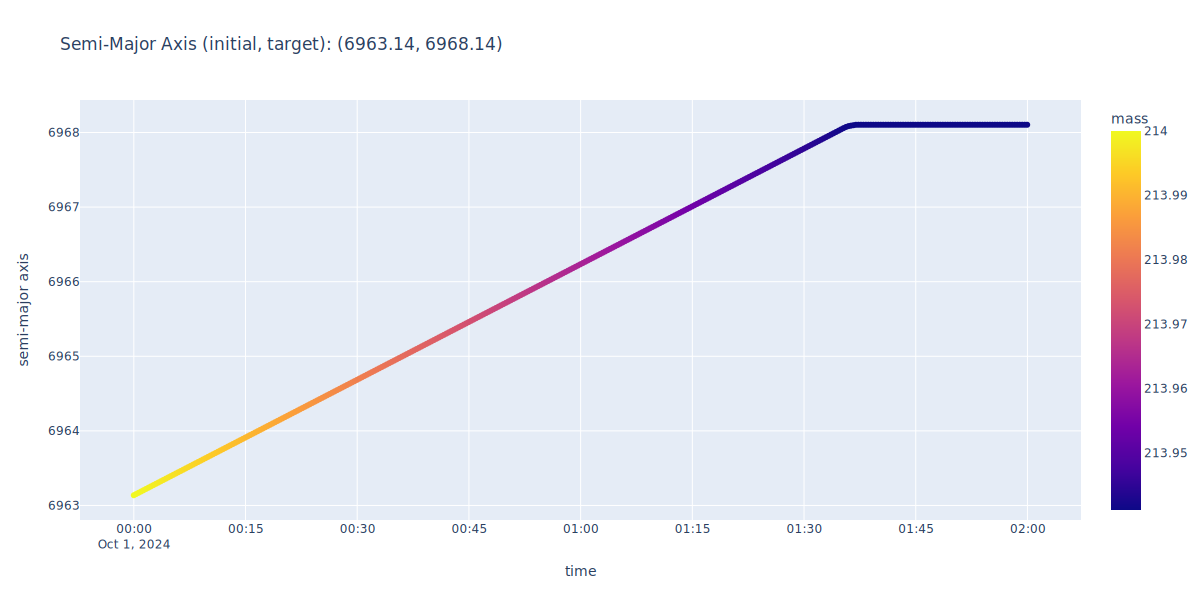

In [13]:
figure = px.scatter(
    df,
    x="time",
    y="semi-major axis",
    color="mass",
    title=f"Semi-Major Axis (initial, target): ({float(coe.get_semi_major_axis().in_kilometers()):.2f}, {float(target_coe.get_semi_major_axis().in_kilometers()):.2f})",
    height=600,
    width=1200,
)
figure.show("svg")

### Eccentricity targeting

In [14]:
# Increasing the COE target SMA as it's osculating
target_coe = COE(
    coe.get_semi_major_axis(),
    coe.get_eccentricity() + 1e-3,
    coe.get_inclination(),
    coe.get_raan(),
    coe.get_aop(),
    coe.get_true_anomaly(),
)
guidance_law = QLaw(
    target_coe,
    EarthGravitationalModel.EGM2008.gravitational_parameter,
    QLaw.Parameters(
        element_weights={COE.Element.Eccentricity: (1.0, 1e-5)},
        m=3,
        n=4,
        r=2,
        k=100,
        periapsis_weight=0.0,
        minimum_periapsis_radius=Length.kilometers(6575.0),
        b=0.01,
    ),
    QLaw.GradientStrategy.Analytical,
)

In [15]:
dynamics = Dynamics.from_environment(environment) + [
    Thruster(
        satellite_system=satellite_system,
        guidance_law=guidance_law,
    )
]
propagator = Propagator(numerical_solver, dynamics)

In [16]:
end_state = propagator.calculate_state_at(
    propagation_state,
    propagation_state.get_instant() + Duration.hours(3.0),
)

In [17]:
df = df_from_states(propagator.access_numerical_solver().get_observed_states(), 10)

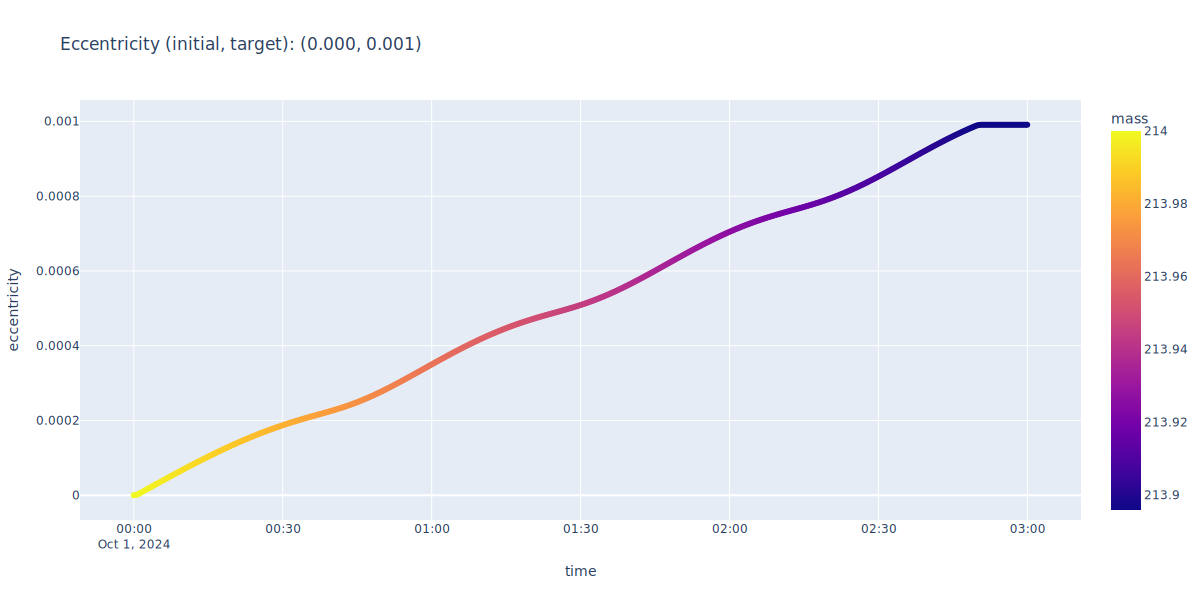

In [18]:
figure = px.scatter(
    df,
    x="time",
    y="eccentricity",
    color="mass",
    title=f"Eccentricity (initial, target): ({float(coe.get_eccentricity()):.3f}, {float(target_coe.get_eccentricity()):.3f})",
    height=600,
    width=1200,
)
figure.show("svg")

### Inclination targeting

In [19]:
# Increasing the COE target SMA as it's osculating
target_coe = COE(
    coe.get_semi_major_axis(),
    coe.get_eccentricity(),
    coe.get_inclination() + Angle.degrees(5e-2),
    coe.get_raan(),
    coe.get_aop(),
    coe.get_true_anomaly(),
)
guidance_law = QLaw(
    target_coe,
    EarthGravitationalModel.EGM2008.gravitational_parameter,
    QLaw.Parameters(
        element_weights={COE.Element.Inclination: (1.0, 1e-5)},
        m=3,
        n=4,
        r=2,
        k=100,
        periapsis_weight=0.0,
        minimum_periapsis_radius=Length.kilometers(6575.0),
        b=0.01,
    ),
    QLaw.GradientStrategy.Analytical,
)

In [20]:
dynamics = Dynamics.from_environment(environment) + [
    Thruster(
        satellite_system=satellite_system,
        guidance_law=guidance_law,
    )
]
propagator = Propagator(numerical_solver, dynamics)

In [21]:
end_state = propagator.calculate_state_at(
    propagation_state,
    propagation_state.get_instant() + Duration.hours(7.0),
)

In [22]:
df = df_from_states(propagator.access_numerical_solver().get_observed_states())

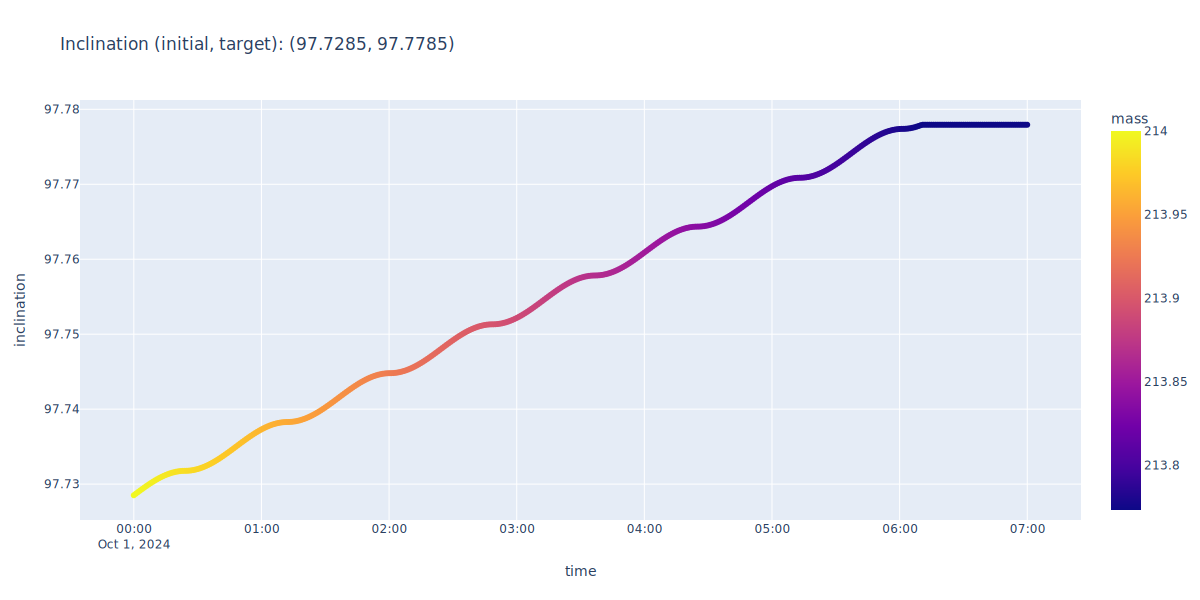

In [23]:
figure = px.scatter(
    df,
    x="time",
    y="inclination",
    color="mass",
    title=f"Inclination (initial, target): ({float(coe.get_inclination().in_degrees()):.4f}, {float(target_coe.get_inclination().in_degrees()):.4f})",
    height=600,
    width=1200,
)
figure.show("svg")

### Right Ascension of Ascending Node targeting

In [24]:
# Increasing the COE target SMA as it's osculating
target_coe = COE(
    coe.get_semi_major_axis(),
    coe.get_eccentricity(),
    coe.get_inclination(),
    coe.get_raan() - Angle.degrees(1e-1),
    coe.get_aop(),
    coe.get_true_anomaly(),
)
guidance_law = QLaw(
    target_coe,
    EarthGravitationalModel.EGM2008.gravitational_parameter,
    QLaw.Parameters(
        element_weights={COE.Element.Raan: (1.0, 1e-6)},
        m=3,
        n=4,
        r=2,
        k=100,
        minimum_periapsis_radius=Length.kilometers(6575.0),
        b=0.01,
    ),
    QLaw.GradientStrategy.Analytical,
)

In [25]:
dynamics = Dynamics.from_environment(environment) + [
    Thruster(
        satellite_system=satellite_system,
        guidance_law=guidance_law,
    )
]
propagator = Propagator(numerical_solver, dynamics)

In [26]:
end_state = propagator.calculate_state_at(
    propagation_state,
    propagation_state.get_instant() + Duration.hours(13.0),
)

In [27]:
df = df_from_states(propagator.access_numerical_solver().get_observed_states())

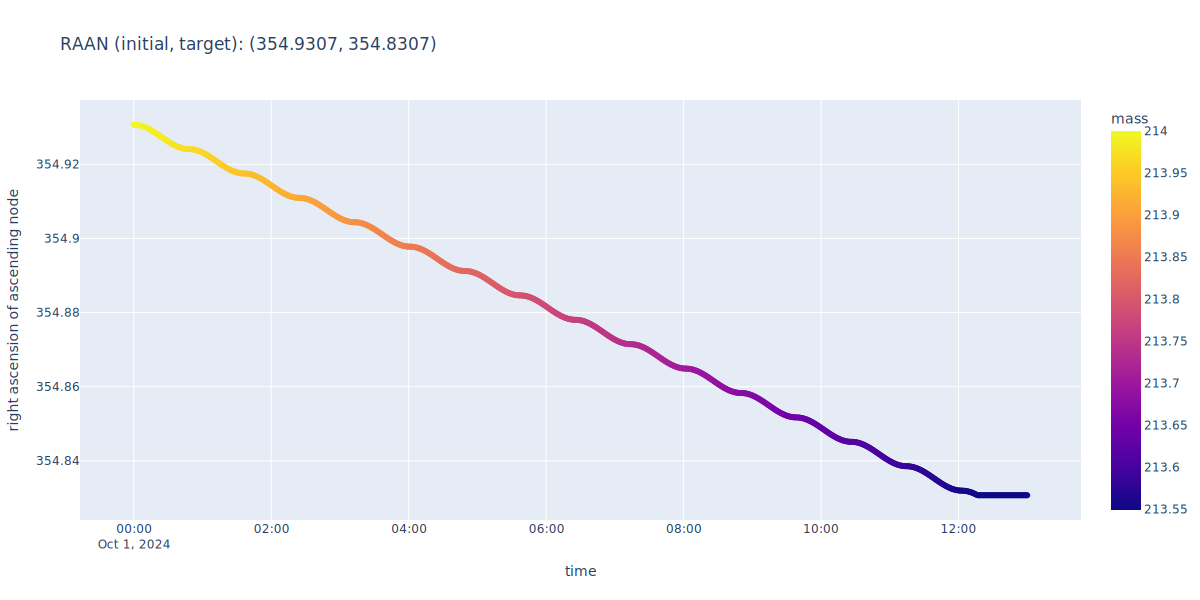

In [28]:
figure = px.scatter(
    df,
    x="time",
    y="right ascension of ascending node",
    color="mass",
    title=f"RAAN (initial, target): ({float(coe.get_raan().in_degrees()):.4f}, {float(target_coe.get_raan().in_degrees()):.4f})",
    height=600,
    width=1200,
)
figure.show("svg")

## Multiple targets

### SMA + Ecc

In [29]:
# Increasing the COE target SMA as it's osculating
target_coe = COE(
    coe.get_semi_major_axis() + Length.kilometers(5.0),
    coe.get_eccentricity() + 0.001,
    coe.get_inclination(),
    coe.get_raan(),
    coe.get_aop(),
    coe.get_true_anomaly(),
)
guidance_law = QLaw(
    target_coe,
    EarthGravitationalModel.EGM2008.gravitational_parameter,
    QLaw.Parameters(
        element_weights={
            COE.Element.SemiMajorAxis: (1.0, 50.0),
            COE.Element.Eccentricity: (1.0, 1e-4),
        },
        m=3,
        n=4,
        r=2,
        k=100,
        minimum_periapsis_radius=Length.kilometers(6575.0),
        b=0.01,
    ),
    QLaw.GradientStrategy.Analytical,
)

dynamics = Dynamics.from_environment(environment) + [
    Thruster(
        satellite_system=satellite_system,
        guidance_law=guidance_law,
    )
]
propagator = Propagator(numerical_solver, dynamics)

In [30]:
end_state = propagator.calculate_state_at(
    propagation_state,
    propagation_state.get_instant() + Duration.hours(4.0),
)

In [31]:
df = df_from_states(propagator.access_numerical_solver().get_observed_states())

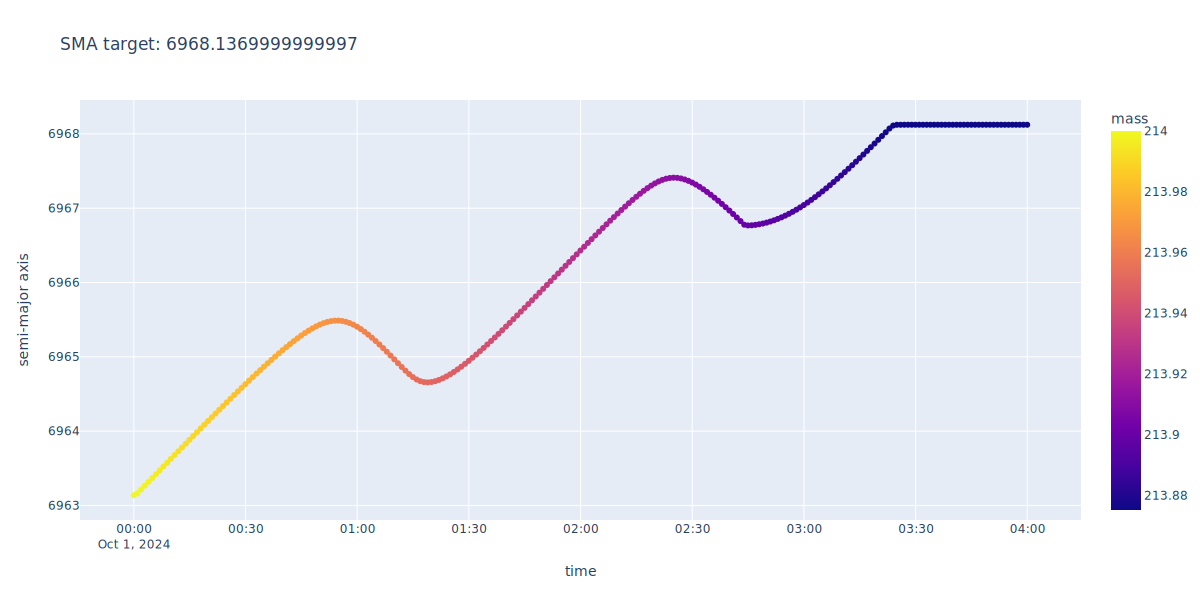

In [32]:
figure = px.scatter(
    df,
    x="time",
    y="semi-major axis",
    color="mass",
    title=f"SMA target: {target_coe.get_semi_major_axis().in_kilometers()}",
    height=600,
    width=1200,
)
figure.show("svg")

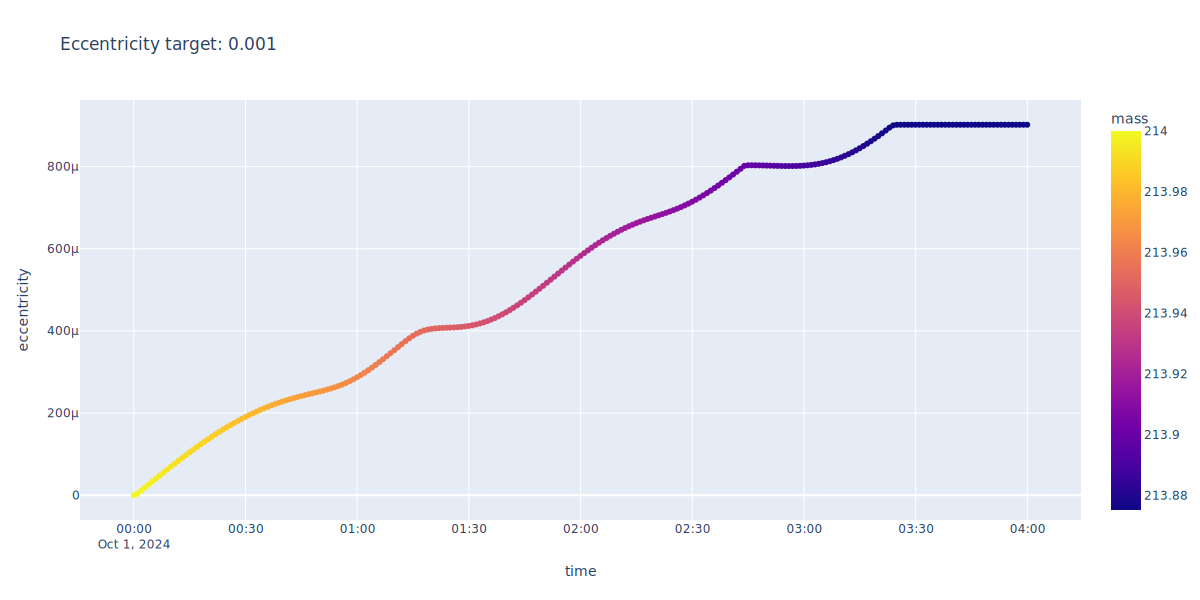

In [33]:
figure = px.scatter(
    df,
    x="time",
    y="eccentricity",
    color="mass",
    title=f"Eccentricity target: {target_coe.get_eccentricity()}",
    height=600,
    width=1200,
)
figure.show("svg")

### Semi Major Axis + Inclination

In [34]:
# Increasing the COE target SMA as it's osculating
target_coe = COE(
    coe.get_semi_major_axis() + Length.kilometers(5.0),
    coe.get_eccentricity(),
    coe.get_inclination() + Angle.degrees(1e-1),
    coe.get_raan(),
    coe.get_aop(),
    coe.get_true_anomaly(),
)
guidance_law = QLaw(
    target_coe,
    EarthGravitationalModel.EGM2008.gravitational_parameter,
    QLaw.Parameters(
        element_weights={
            COE.Element.SemiMajorAxis: (1.0, 50.0),
            COE.Element.Inclination: (1.0, 1e-5),
        },
        m=3,
        n=4,
        r=2,
        k=100,
        minimum_periapsis_radius=Length.kilometers(6575.0),
        b=0.01,
    ),
    QLaw.GradientStrategy.Analytical,
)

dynamics = Dynamics.from_environment(environment) + [
    Thruster(
        satellite_system=satellite_system,
        guidance_law=guidance_law,
    )
]
propagator = Propagator(numerical_solver, dynamics)

In [35]:
end_state = propagator.calculate_state_at(
    propagation_state,
    propagation_state.get_instant() + Duration.hours(15.0),
)

In [36]:
df = df_from_states(propagator.access_numerical_solver().get_observed_states())

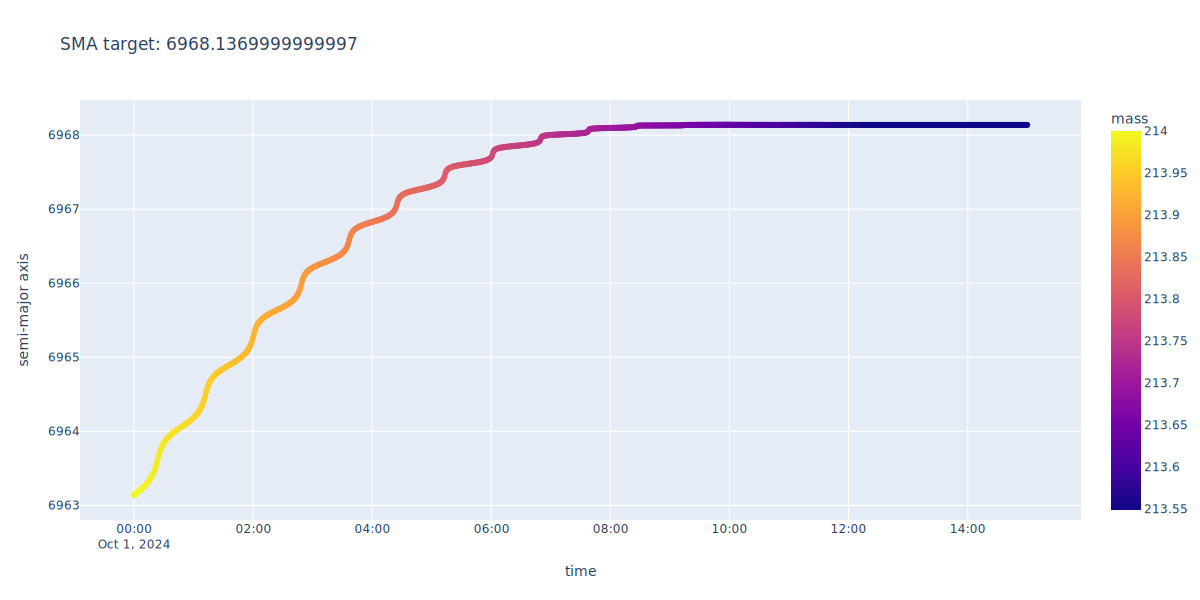

In [37]:
figure = px.scatter(
    df,
    x="time",
    y="semi-major axis",
    color="mass",
    title=f"SMA target: {target_coe.get_semi_major_axis().in_kilometers()}",
    height=600,
    width=1200,
)
figure.show("svg")

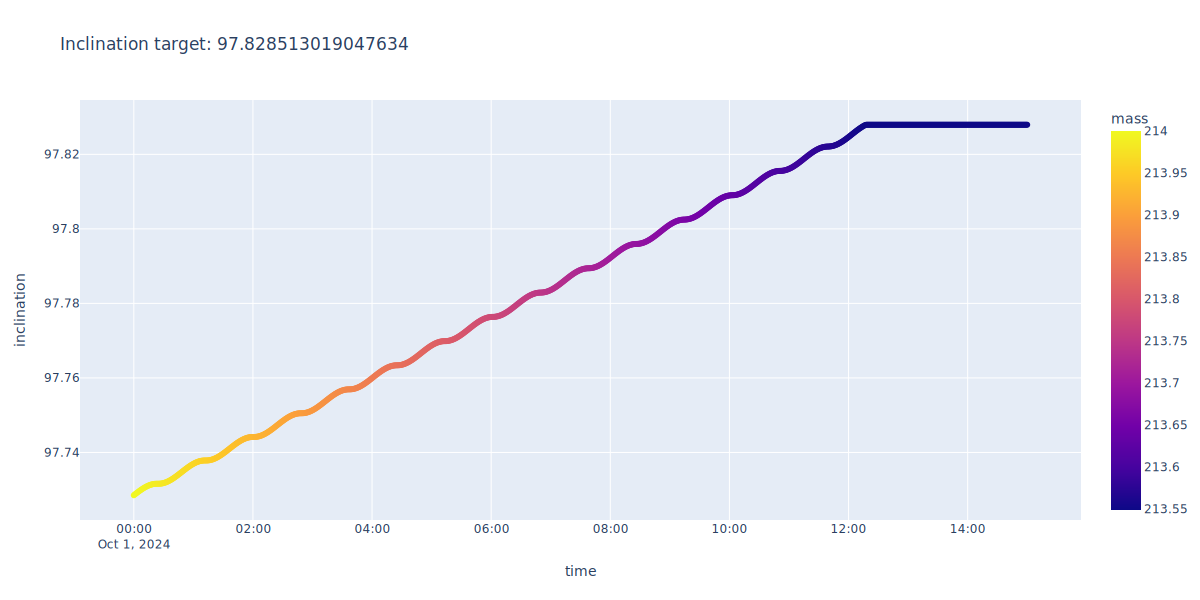

In [38]:
figure = px.scatter(
    df,
    x="time",
    y="inclination",
    color="mass",
    title=f"Inclination target: {target_coe.get_inclination().in_degrees()}",
    height=600,
    width=1200,
)
figure.show("svg")

### SMA + Ecc + Inclination

In [39]:
target_coe = COE(
    coe.get_semi_major_axis() + Length.kilometers(5.0),
    coe.get_eccentricity() + 0.001,
    coe.get_inclination() + Angle.degrees(1e-1),
    coe.get_raan(),
    coe.get_aop(),
    coe.get_true_anomaly(),
)
guidance_law = QLaw(
    target_coe,
    EarthGravitationalModel.EGM2008.gravitational_parameter,
    QLaw.Parameters(
        element_weights={
            COE.Element.SemiMajorAxis: (1.0, 50.0),
            COE.Element.Eccentricity: (1.0, 1e-5),
            COE.Element.Inclination: (1.0, 1e-5),
        },
        m=3,
        n=4,
        r=2,
        k=100,
        minimum_periapsis_radius=Length.kilometers(6575.0),
        b=0.01,
    ),
    QLaw.GradientStrategy.Analytical,
)

dynamics = Dynamics.from_environment(environment) + [
    Thruster(
        satellite_system=satellite_system,
        guidance_law=guidance_law,
    )
]
propagator = Propagator(numerical_solver, dynamics)

In [40]:
end_state = propagator.calculate_state_at(
    propagation_state,
    propagation_state.get_instant() + Duration.hours(14.0),
)

In [41]:
df = df_from_states(propagator.access_numerical_solver().get_observed_states())

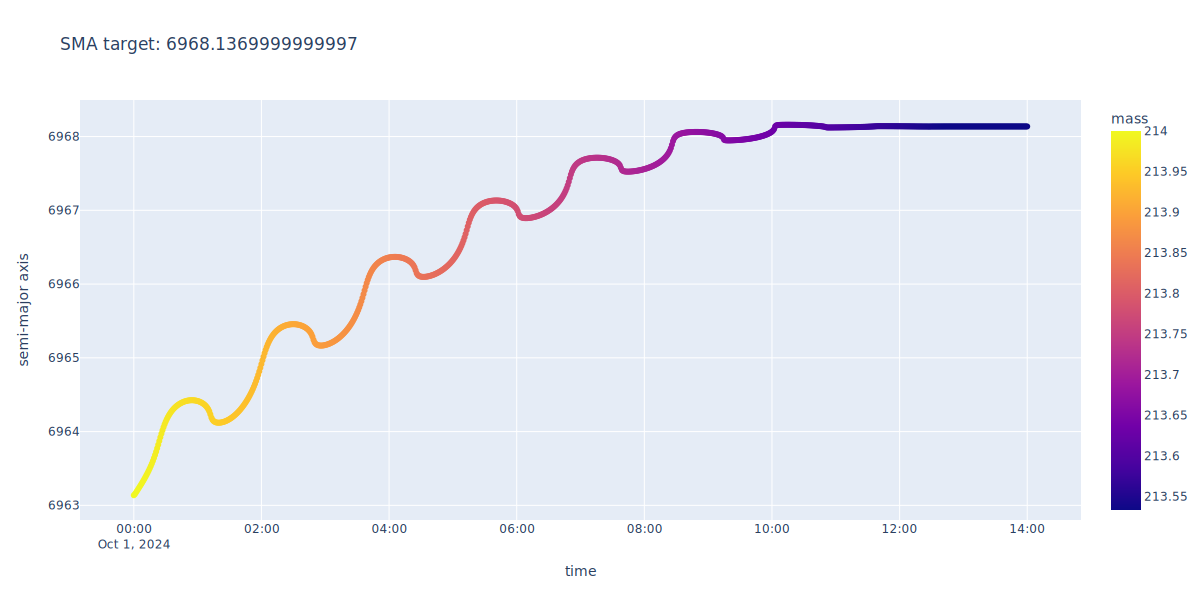

In [42]:
figure = px.scatter(
    df,
    x="time",
    y="semi-major axis",
    color="mass",
    title=f"SMA target: {target_coe.get_semi_major_axis().in_kilometers()}",
    height=600,
    width=1200,
)
figure.show("svg")

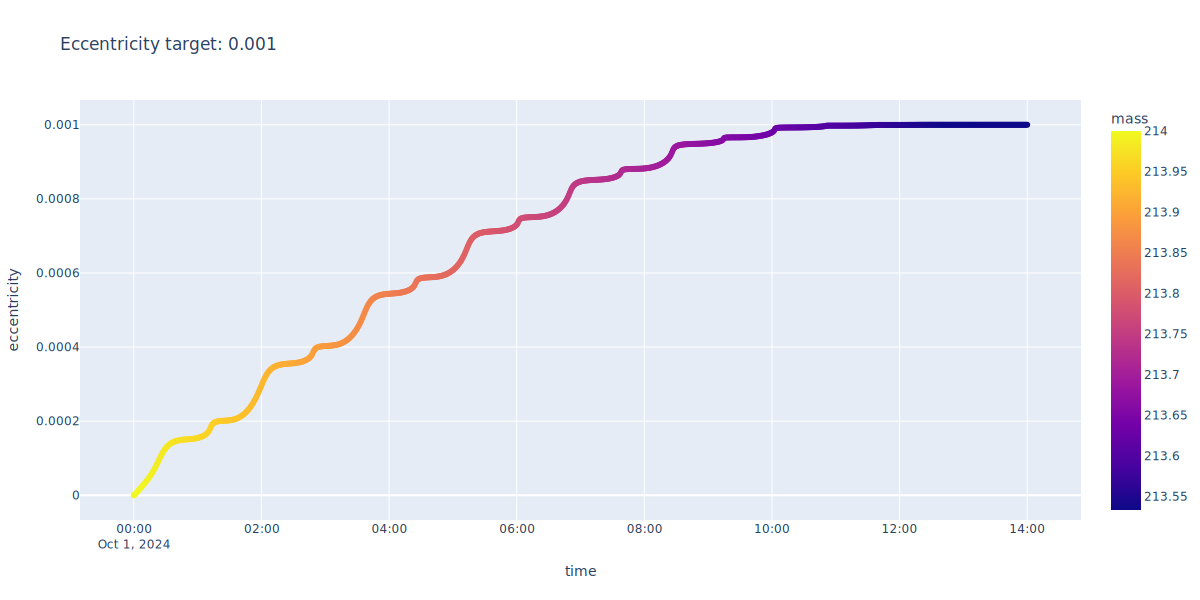

In [43]:
figure = px.scatter(
    df,
    x="time",
    y="eccentricity",
    color="mass",
    title=f"Eccentricity target: {target_coe.get_eccentricity()}",
    height=600,
    width=1200,
)
figure.show("svg")

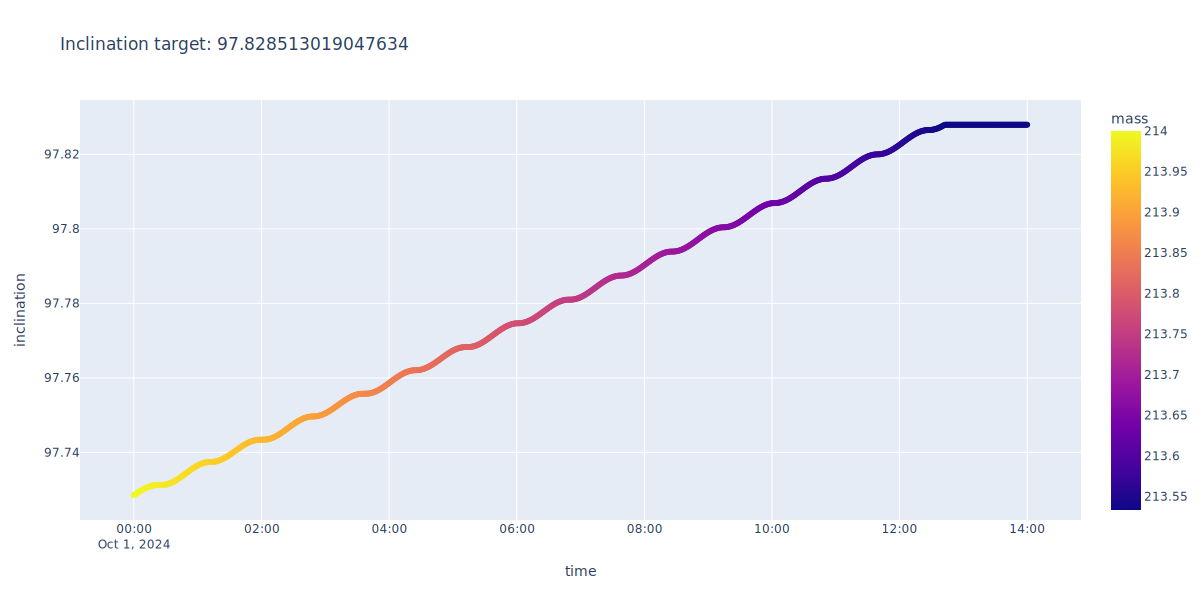

In [44]:
figure = px.scatter(
    df,
    x="time",
    y="inclination",
    color="mass",
    title=f"Inclination target: {target_coe.get_inclination().in_degrees()}",
    height=600,
    width=1200,
)
figure.show("svg")

### SMA + Ecc + Inc + Raan targeting

In [45]:
target_coe = COE(
    coe.get_semi_major_axis() + Length.kilometers(5.0),
    coe.get_eccentricity() + 0.001,
    coe.get_inclination() + Angle.degrees(1e-1),
    coe.get_raan() - Angle.degrees(1e-1),
    coe.get_aop(),
    coe.get_true_anomaly(),
)
guidance_law = QLaw(
    target_coe,
    EarthGravitationalModel.EGM2008.gravitational_parameter,
    QLaw.Parameters(
        element_weights={
            COE.Element.SemiMajorAxis: (1.0, 50.0),
            COE.Element.Eccentricity: (1.0, 1e-5),
            COE.Element.Inclination: (1.0, 1e-5),
            COE.Element.Raan: (1.0, 1e-5),
        },
        m=3,
        n=4,
        r=2,
        k=100,
        minimum_periapsis_radius=Length.kilometers(6575.0),
        b=0.01,
    ),
    QLaw.GradientStrategy.FiniteDifference,
)

dynamics = Dynamics.from_environment(environment) + [
    Thruster(
        satellite_system=satellite_system,
        guidance_law=guidance_law,
    )
]
propagator = Propagator(numerical_solver, dynamics)

In [46]:
end_state = propagator.calculate_state_at(
    propagation_state,
    propagation_state.get_instant() + Duration.hours(24.0),
)

In [47]:
df = df_from_states(propagator.access_numerical_solver().get_observed_states())

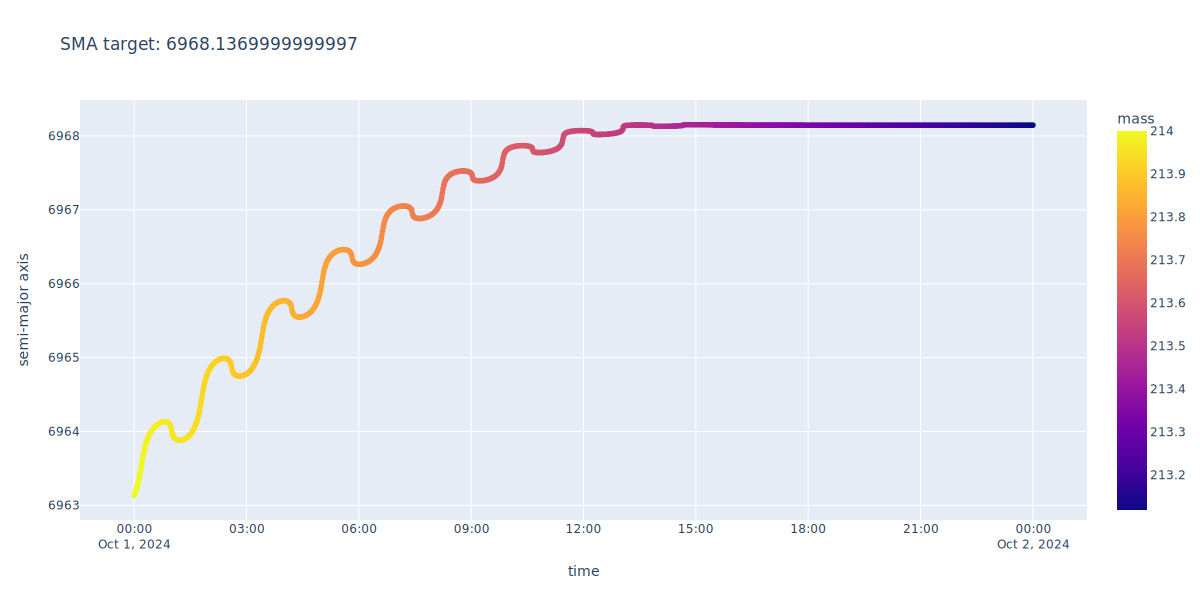

In [48]:
figure = px.scatter(
    df,
    x="time",
    y="semi-major axis",
    color="mass",
    title=f"SMA target: {target_coe.get_semi_major_axis().in_kilometers()}",
    height=600,
    width=1200,
)
figure.show("svg")

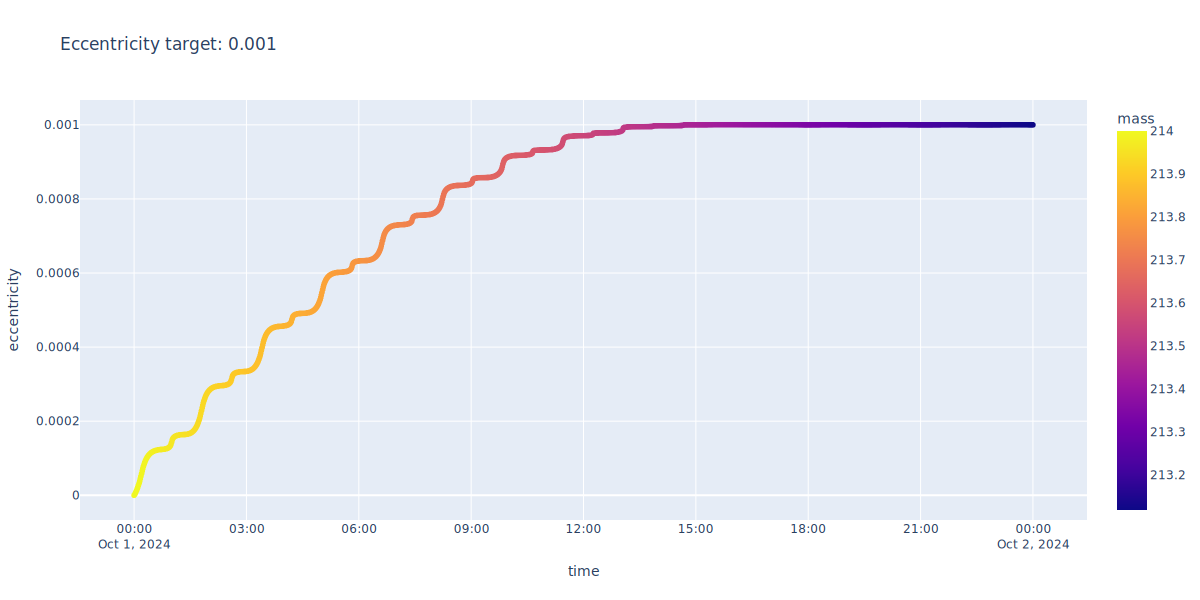

In [49]:
figure = px.scatter(
    df,
    x="time",
    y="eccentricity",
    color="mass",
    title=f"Eccentricity target: {target_coe.get_eccentricity()}",
    height=600,
    width=1200,
)
figure.show("svg")

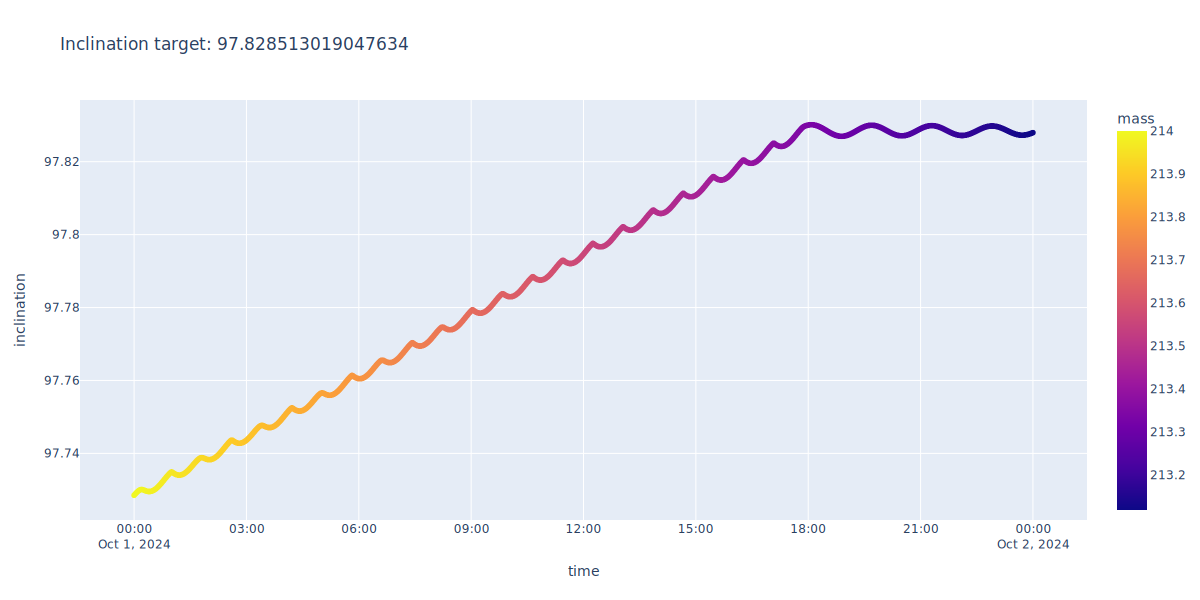

In [50]:
figure = px.scatter(
    df,
    x="time",
    y="inclination",
    color="mass",
    title=f"Inclination target: {target_coe.get_inclination().in_degrees()}",
    height=600,
    width=1200,
)
figure.show("svg")

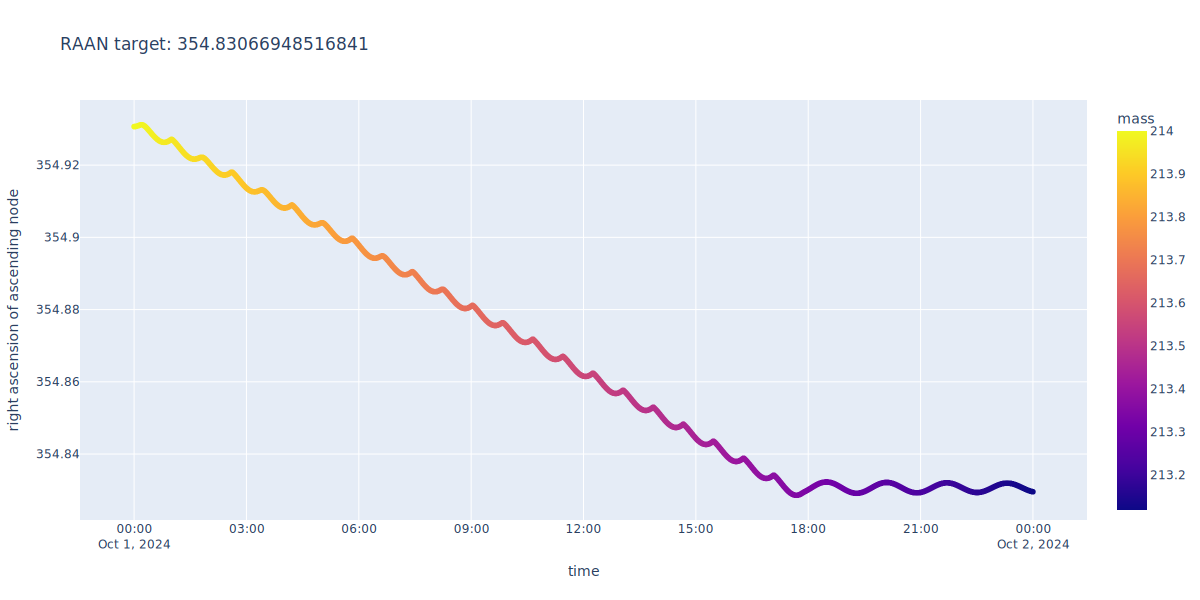

In [51]:
figure = px.scatter(
    df,
    x="time",
    y="right ascension of ascending node",
    color="mass",
    title=f"RAAN target: {target_coe.get_raan().in_degrees()}",
    height=600,
    width=1200,
)
figure.show("svg")

---